# 0. NOTES

* feature `real_face` could be removed, it provides no extra information to the dataset
* without `player_name` information we loose track of how many unique instances there could be

---
# 1. Imports

In [105]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [282]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost.sklearn import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from catboost import CatBoostRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, SCORERS
from sklearn.model_selection import cross_val_score, cross_validate
import random

In [107]:
set_config(display='diagram')

In [108]:
random.seed(42)

---
# 2. Data importing

In [109]:
data = pd.read_csv('../../raw_data/master_data_train.csv')

In [110]:
data.head()

,Unnamed: 0,fee_cleaned,age,height_cm,weight_kg,nationality,club_name,league_name,league_rank,overall,...,lb,lcb,cb,rcb,rb,fifa year,national_team,seasons_with_club,on_loan,remaining_seasons_on_contract
0,1802,4.50,19,175,75,Italy,FC Sion,Swiss Super League,1.0,63,...,62,61,61,61,62,2018,0,1,0,3.0
1,3828,4.50,18,188,80,France,Paris Saint-Germain,French Ligue 1,1.0,67,...,63,66,66,66,63,2020,0,1,0,1.0
2,3349,5.72,18,183,66,Ecuador,Club Atlético Talleres,Argentina Primera División,1.0,58,...,55,58,58,58,55,2021,0,1,0,4.0
3,1806,8.10,27,187,80,Russia,FC Krasnodar,Russian Premier League,1.0,80,...,53,49,49,49,53,2018,1,3,0,1.0
4,3328,0.90,24,185,76,Serbia,Olympique de Marseille,French Ligue 1,1.0,74,...,51,42,42,42,51,2021,0,3,0,2.0


In [111]:
data = data.drop(columns=['Unnamed: 0'])
data.head()

,fee_cleaned,age,height_cm,weight_kg,nationality,club_name,league_name,league_rank,overall,potential,...,lb,lcb,cb,rcb,rb,fifa year,national_team,seasons_with_club,on_loan,remaining_seasons_on_contract
0,4.50,19,175,75,Italy,FC Sion,Swiss Super League,1.0,63,77,...,62,61,61,61,62,2018,0,1,0,3.0
1,4.50,18,188,80,France,Paris Saint-Germain,French Ligue 1,1.0,67,83,...,63,66,66,66,63,2020,0,1,0,1.0
2,5.72,18,183,66,Ecuador,Club Atlético Talleres,Argentina Primera División,1.0,58,78,...,55,58,58,58,55,2021,0,1,0,4.0
3,8.10,27,187,80,Russia,FC Krasnodar,Russian Premier League,1.0,80,81,...,53,49,49,49,53,2018,1,3,0,1.0
4,0.90,24,185,76,Serbia,Olympique de Marseille,French Ligue 1,1.0,74,79,...,51,42,42,42,51,2021,0,3,0,2.0


In [113]:
list(data.columns)

['fee_cleaned',
 'age',
 'height_cm',
 'weight_kg',
 'nationality',
 'club_name',
 'league_name',
 'league_rank',
 'overall',
 'potential',
 'wage_eur',
 'player_positions',
 'preferred_foot',
 'international_reputation',
 'weak_foot',
 'skill_moves',
 'work_rate',
 'body_type',
 'real_face',
 'release_clause_eur',
 'player_tags',
 'team_position',
 'team_jersey_number',
 'pace',
 'shooting',
 'passing',
 'dribbling',
 'defending',
 'physic',
 'gk_diving',
 'gk_handling',
 'gk_kicking',
 'gk_reflexes',
 'gk_speed',
 'gk_positioning',
 'player_traits',
 'attacking_crossing',
 'attacking_finishing',
 'attacking_heading_accuracy',
 'attacking_short_passing',
 'attacking_volleys',
 'skill_dribbling',
 'skill_curve',
 'skill_fk_accuracy',
 'skill_long_passing',
 'skill_ball_control',
 'movement_acceleration',
 'movement_sprint_speed',
 'movement_agility',
 'movement_reactions',
 'movement_balance',
 'power_shot_power',
 'power_jumping',
 'power_stamina',
 'power_strength',
 'power_long_shot

<AxesSubplot:>

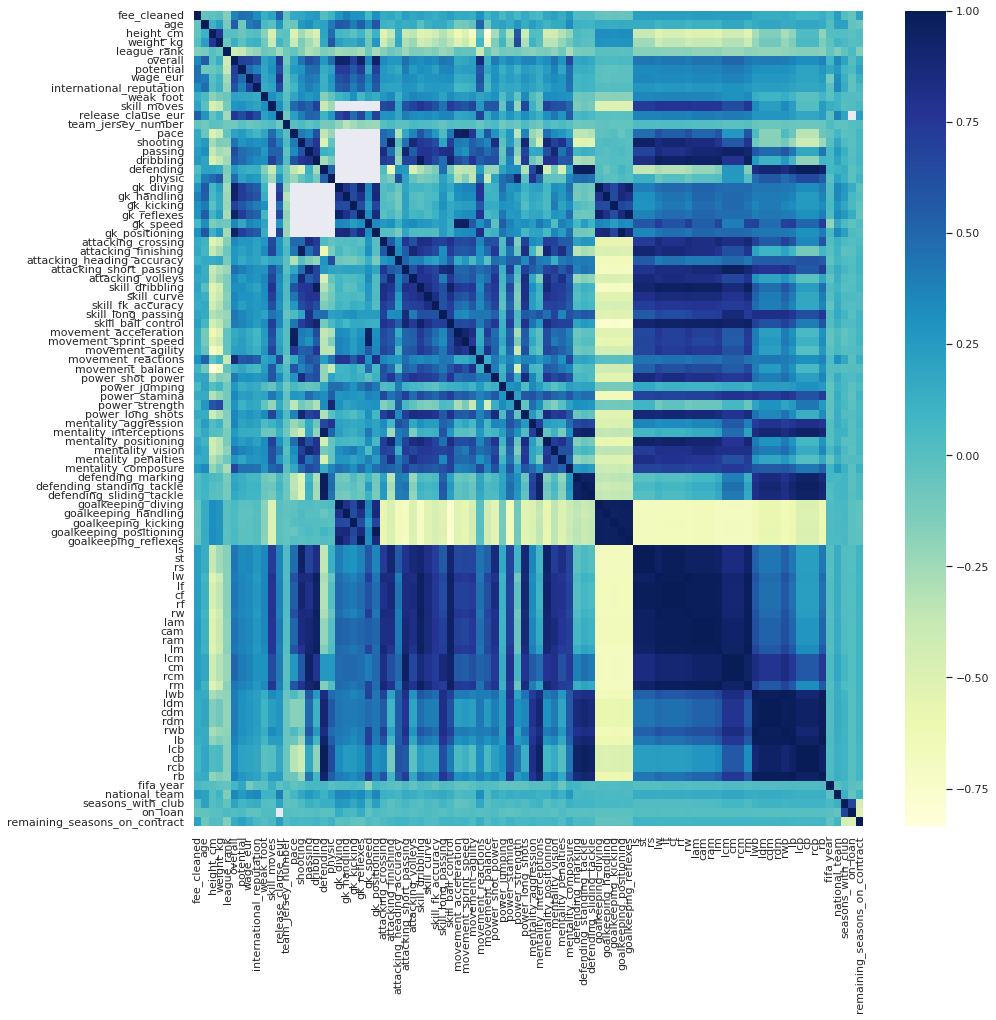

In [114]:
corr = data.corr()
sns.set(rc = {'figure.figsize':(15,15)})
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap= "YlGnBu")

---
# 3. BUILDING MODELS

## 3.1. `3 Feature` model

As seen in previous data exploration, a players `age`, `potential` and `overall` features seem to carry an influence on how much it can be worth. In order to get a sense on how this 3 features can influence the players market value I will start by building a model only containing these dimensions

In [268]:
X_train = data[['age', 'potential', 'overall']]
y_train = data.fee_cleaned

In [269]:
X_train

,age,potential,overall
0,19,77,63
1,18,83,67
2,18,78,58
3,27,81,80
4,24,79,74
...,...,...,...
3127,24,80,76
3128,26,72,70
3129,22,84,75
3130,19,86,68


In [270]:
simple_model = LinearRegression()

In [271]:
cross_val_score(simple_model, X_train, y_train, cv=5, scoring='r2').mean()

0.22867421742332344

In [273]:
# cat_boost_model = CatBoostRegressor()
# cross_val_score(cat_boost_model, X_train, y_train, cv=5, scoring='r2').mean()
# cross_val_score for this cell was 0.250713275509307

### 3.1.1. Look at the variables distribution and scale them accordingly

#### age

<AxesSubplot:xlabel='age', ylabel='Count'>

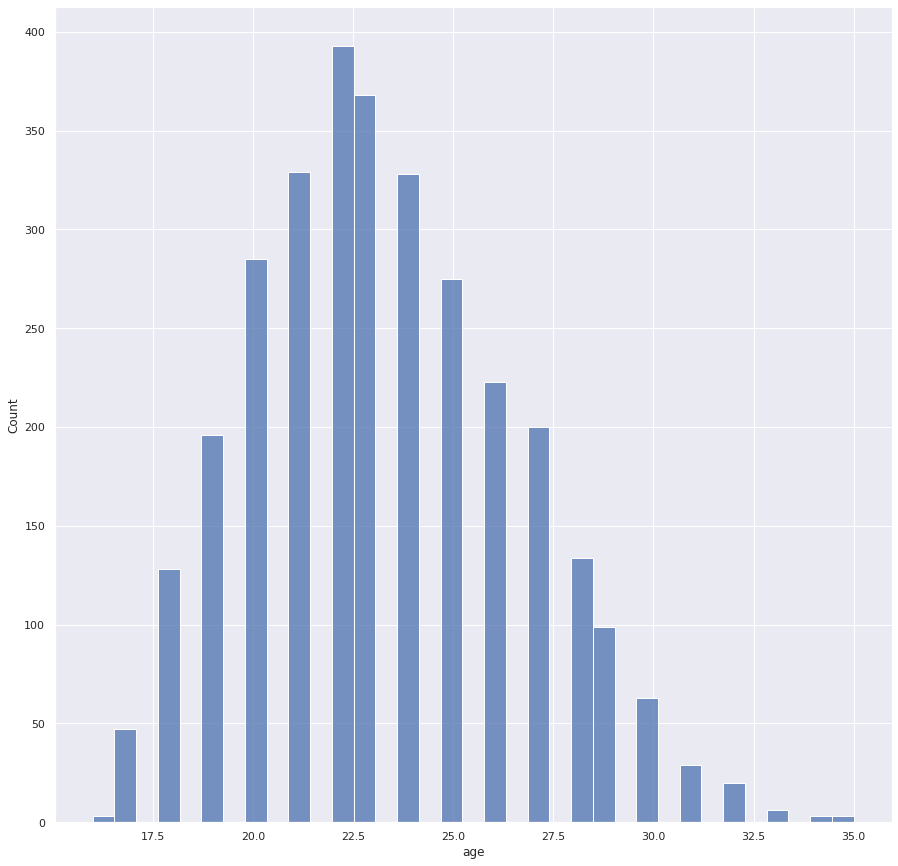

In [119]:
sns.histplot(data=X_train , x='age')

`age` seems to follow a normal distribution centered around 22.5 years, we can check for **outliers** to choose which standardization technique to use

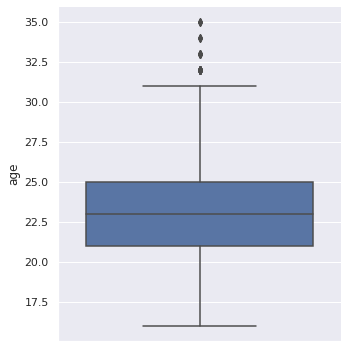

In [120]:
sns.catplot(data=X_train,y='age', kind='box')

In [121]:
X_train[X_train.age > 31]['age'].count()

32

There are 32 players over the age of 31. I dont want to drop these outliers, so I will choose to use a **Robust Scaler**

<AxesSubplot:xlabel='overall', ylabel='Count'>

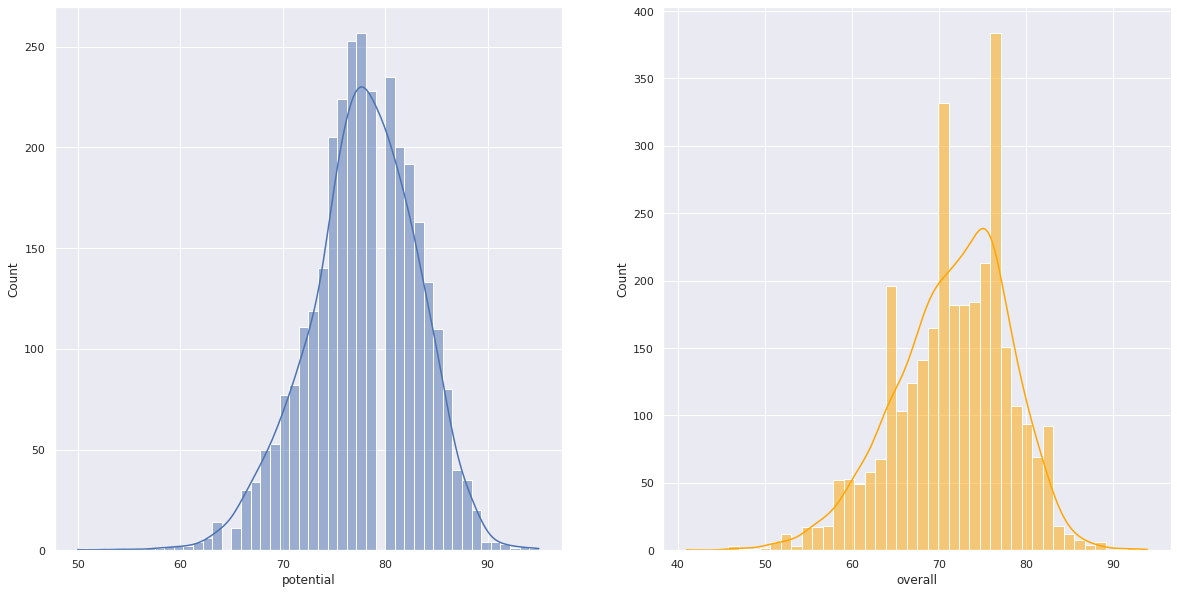

In [122]:
sns.set(rc = {'figure.figsize':(20,10)})
fig, ax = plt.subplots(nrows=1, ncols=2)
sns.histplot(data=X_train, x='potential', ax=ax[0], kde=True)
sns.histplot(data=X_train, x='overall', ax=ax[1], kde=True, color='orange')

/home/joaor/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/seaborn/categorical.py:3775: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try boxplot
  warnings.warn(msg, UserWarning)
/home/joaor/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/seaborn/categorical.py:3775: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try boxplot
  warnings.warn(msg, UserWarning)


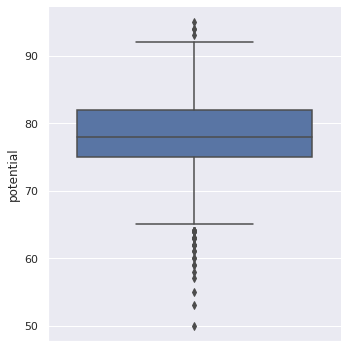

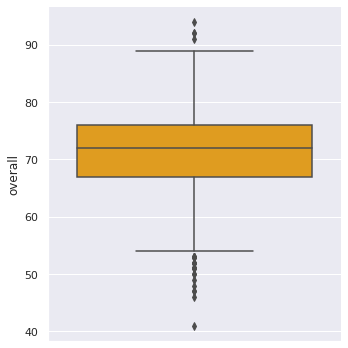

In [123]:
sns.catplot(data=X_train, y='potential', ax=ax[0],kind='box')
sns.catplot(data=X_train, y='overall', ax=ax[1], kind='box', color='orange')

In [124]:
r_scaler = RobustScaler()

In [125]:
r_scaler.fit(X_train[['age']])
X_train['age'] = r_scaler.transform(X_train[['age']])

/tmp/ipykernel_3198/661161478.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['age'] = r_scaler.transform(X_train[['age']])


In [126]:
r_scaler.fit(X_train[['potential']])
X_train['potential'] = r_scaler.transform(X_train[['potential']])

/tmp/ipykernel_3198/4266490664.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['potential'] = r_scaler.transform(X_train[['potential']])


In [127]:
r_scaler.fit(X_train[['overall']])
X_train['overall'] = r_scaler.transform(X_train[['overall']])

/tmp/ipykernel_3198/1744354320.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['overall'] = r_scaler.transform(X_train[['overall']])


In [128]:
X_train

,age,potential,overall
0,-1.00,-0.142857,-1.000000
1,-1.25,0.714286,-0.555556
2,-1.25,0.000000,-1.555556
3,1.00,0.428571,0.888889
4,0.25,0.142857,0.222222
...,...,...,...
3127,0.25,0.285714,0.444444
3128,0.75,-0.857143,-0.222222
3129,-0.25,0.857143,0.333333
3130,-1.00,1.142857,-0.444444


In [129]:
cv_scaled_results = cross_val_score(simple_model, X_train, y_train, cv=5, scoring='r2').mean()

In [130]:
cv_scaled_results

0.22867421742332353

**NOTE**: It makes no difference to scale the features in our model!

## 3.2. Adding `wage_eur` to the model

In [275]:
features_used = ['age', 'potential', 'overall', 'wage_eur']

In [276]:
X_train = data[features_used].copy()

In [277]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [278]:
X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled

,0,1,2,3
0,-1.00,-0.142857,-1.000000,-0.529412
1,-1.25,0.714286,-0.555556,-0.411765
2,-1.25,0.000000,-1.555556,-0.569118
3,1.00,0.428571,0.888889,1.176471
4,0.25,0.142857,0.222222,0.294118
...,...,...,...,...
3127,0.25,0.285714,0.444444,0.294118
3128,0.75,-0.857143,-0.222222,0.588235
3129,-0.25,0.857143,0.333333,-0.323529
3130,-1.00,1.142857,-0.444444,-0.147059


In [279]:
linear_model = LinearRegression()

In [280]:
cv_scaled_results = cross_val_score(linear_model, X_train_scaled, y_train, cv=5, scoring='r2').mean()
cv_scaled_results

0.30163624502998015

In [284]:
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [289]:
cv_lin_reg = cross_validate(linear_model, X_train_scaled, y_train, cv=5, scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'max_error', 'r2'])

In [294]:
cv_lin_reg

{'fit_time': array([0.00909424, 0.00602198, 0.00402427, 0.0051322 , 0.00766301]),
 'score_time': array([0.00661922, 0.00781608, 0.01202893, 0.00488806, 0.00500917]),
 'test_neg_mean_absolute_error': array([-5.59729758, -5.77051327, -5.36449037, -5.5420488 , -4.80884287]),
 'test_neg_mean_squared_error': array([ -95.57031397,  -94.73376284,  -99.25900146, -113.64242976,
         -44.51485282]),
 'test_max_error': array([-108.44465862, -106.78102835, -104.10327961, -137.73769654,
         -49.64343611]),
 'test_r2': array([0.27108116, 0.18260806, 0.29656696, 0.35039994, 0.4075251 ])}

In [299]:
results_cv_lin_reg = {}
for key, value in cv_lin_reg.items():
    results_cv_lin_reg[key] = value.mean()

pd.DataFrame.from_dict(results_cv_lin_reg, orient='index', columns=['linear_regression'])

,linear_regression
fit_time,0.006387
score_time,0.007272
test_neg_mean_absolute_error,-5.416639
test_neg_mean_squared_error,-89.544072
test_max_error,-101.342020
test_r2,0.301636


## 3.3. Adding `release_clause_eur` to the model

In [137]:
features_used = ['age', 'potential', 'overall', 'wage_eur', 'release_clause_eur']
X_train = data[features_used].copy()
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled)
linear_model = LinearRegression()

# imputing values in the release clause
imputer = SimpleImputer(strategy="most_frequent")
imputer.fit(X_train_scaled[[4]])
X_train_scaled[4] = imputer.transform(X_train_scaled[[4]])

cv_scaled_results = cross_val_score(linear_model, X_train_scaled, y_train, cv=5, scoring='r2').mean()
cv_scaled_results

0.31054404407185376

### 3.3.1. `RIDGE` vs. `LASSO` 

In [138]:
features_used = ['age', 'potential', 'overall', 'wage_eur', 'release_clause_eur']
X_train = data[features_used].copy()
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled)
ridge_model = Ridge()

# imputing values in the release clause
imputer = SimpleImputer(strategy="most_frequent")
imputer.fit(X_train_scaled[[4]])
X_train_scaled[4] = imputer.transform(X_train_scaled[[4]])

cv_scaled_results_ridge = cross_val_score(ridge_model, X_train_scaled, y_train, cv=5, scoring='r2').mean()
cv_scaled_results_ridge

0.31056724014361553

In [139]:
features_used = ['age', 'potential', 'overall', 'wage_eur', 'release_clause_eur']
X_train = data[features_used].copy()
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled)
lasso_model = Lasso()

# imputing values in the release clause
imputer = SimpleImputer(strategy="most_frequent")
imputer.fit(X_train_scaled[[4]])
X_train_scaled[4] = imputer.transform(X_train_scaled[[4]])

cv_scaled_results_lasso = cross_val_score(lasso_model, X_train_scaled, y_train, cv=5, scoring='r2').mean()
cv_scaled_results_lasso

0.26965748141658763

## 3.4. Creating a Pipeline

In [140]:
features_used = ['age', 'potential', 'overall', 'wage_eur', 'release_clause_eur']

In [141]:
X_train = data[features_used]

In [142]:
num_transformer = make_pipeline(SimpleImputer(), RobustScaler())

preprocessor = make_column_transformer((num_transformer, features_used), remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('robustscaler',
                                                  RobustScaler())]),
                                 ['age', 'potential', 'overall', 'wage_eur',
                                  'release_clause_eur'])])

In [143]:
X_train_transformed = preprocessor.fit_transform(X_train)

In [144]:
pd.DataFrame(X_train_transformed)

,0,1,2,3,4
0,-1.00,-0.142857,-1.000000,-0.529412,-6.293404
1,-1.25,0.714286,-0.555556,-0.411765,-5.244711
2,-1.25,0.000000,-1.555556,-0.569118,-6.730360
3,1.00,0.428571,0.888889,1.176471,6.740355
4,0.25,0.142857,0.222222,0.294118,0.348320
...,...,...,...,...,...
3127,0.25,0.285714,0.444444,0.294118,0.000000
3128,0.75,-0.857143,-0.222222,0.588235,0.000000
3129,-0.25,0.857143,0.333333,-0.323529,5.042471
3130,-1.00,1.142857,-0.444444,-0.147059,-4.595520


In [145]:
pipe = make_pipeline(preprocessor, Ridge())

In [146]:
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['age', 'potential',
                                                   'overall', 'wage_eur',
                                                   'release_clause_eur'])])),
                ('ridge', Ridge())])

In [147]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['age', 'potential',
                                                   'overall', 'wage_eur',
                                                   'release_clause_eur'])])),
                ('ridge', Ridge())])

In [148]:
cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2').mean()

0.30641439739610526

## 3.5. `linear` VS. `ridge` VS. `lasso`

In [149]:
regressors = {
    'linear': LinearRegression(),
    'ridge': Ridge(),
    'lasso': Lasso()
}

features_used = ['age', 'potential', 'overall', 'wage_eur', 'release_clause_eur']
X_train = data[features_used]

In [150]:
num_transformer = make_pipeline(SimpleImputer(), RobustScaler())

preprocessor = make_column_transformer((num_transformer, features_used), remainder='passthrough')

scores = {}

for name, regressor in regressors.items():
    pipe = make_pipeline(preprocessor, regressor)
    scores[name] = cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2').mean()


pd.DataFrame.from_dict(scores, orient='index', columns=['r2 score'])
# scores

,r2 score
linear,0.306389
ridge,0.306414
lasso,0.271432


# 3.6. Physical atributes

---

'preferred_foot',
 'international_reputation',
 'weak_foot',
 'skill_moves',
 'work_rate',
 'body_type',
 'real_face',
 'release_clause_eur',
 'player_tags',
 'team_position',
 'team_jersey_number',
 'pace',
 'shooting',
 'passing',
 'dribbling',
 'defending',
 'physic',
 'gk_diving',
 'gk_handling',
 'gk_kicking',
 'gk_reflexes',
 'gk_speed',
 'gk_positioning',
 'player_traits',
 'attacking_crossing',
 'attacking_finishing',
 'attacking_heading_accuracy',
 'attacking_short_passing',
 'attacking_volleys',
 'skill_dribbling',
 'skill_curve',
 'skill_fk_accuracy',
 'skill_long_passing',
 'skill_ball_control',
 'movement_acceleration',
 'movement_sprint_speed',
 'movement_agility',
 'movement_reactions',
 'movement_balance',
 'power_shot_power',
 'power_jumping',
 'power_stamina',
 'power_strength',
 'power_long_shots',
 'mentality_aggression',
 'mentality_interceptions',
 'mentality_positioning',
 'mentality_vision',
 'mentality_penalties',
 'mentality_composure',
 'defending_marking',
 'defending_standing_tackle',
 'defending_sliding_tackle'
 
 ---

👆🏼 above are listed the aailable players physical atributes (aside from some others) that we could use to determine its market value.

Lets take a look and decide how to include them in our model

### 3.6.1. `preferred foot`

the preferred foot is a binary feature with values being `left` or `right`, we can perform a OneHotEncoding on this feature and drop one of them

In [151]:
features_used = ['age', 'potential', 'overall', 'wage_eur', 'release_clause_eur', 'preferred_foot']

In [152]:
# for feature in features_used:
#     print(data[feature].dtype)

In [153]:
X_train = data[features_used]

num_transformer = make_pipeline(SimpleImputer(), RobustScaler())
num_col = make_column_selector(dtype_include=['float64', 'int64'])

cat_transformer = OneHotEncoder(drop='if_binary')
cat_col = make_column_selector(dtype_include=['object','bool'])

preprocessor = make_column_transformer(
    (num_transformer, num_col),
    (cat_transformer, cat_col),
    remainder='passthrough')

scores = {}

for name, regressor in regressors.items():
    pipe = make_pipeline(preprocessor, regressor)
    scores[name] = cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2').mean()


pd.DataFrame.from_dict(scores, orient='index', columns=['r2 score'])
# scores

,r2 score
linear,0.306074
ridge,0.306100
lasso,0.271432


adding the preferred foot in our model slightly reduced the $R^2$

### 3.6.2. `skill_moves`, `work_rate`, `body_type`

In [154]:
data.skill_moves.dtype

dtype('int64')

In [155]:
data.work_rate.unique()

array(['High/Medium', 'Medium/Medium', 'High/Low', 'High/High',
       'Medium/Low', 'Medium/High', 'Low/Medium', 'Low/High'],
      dtype=object)

* **`work_rate`** dictate where players position themselves on the pitch. Also known as Player Work Rate, **it is the rate of a player’s behaviour on the pitch in terms of attacking and defensive works.**

* A high attacking work rate implies that the player is going to be in all of your attack moves. With medium, he will select the attack actions he will join. A player with low attacking work rate will remain in his position while the team attacks. With the defence, it is exactly the same but in the opposite direction.

* as a method of separation we could possibly separate the `work_rate` into 

In [156]:
data.body_type.unique()

array(['Normal', 'Lean', 'Stocky', 'PLAYER_BODY_TYPE_351',
       'PLAYER_BODY_TYPE_301', 'Courtois', 'C. Ronaldo', 'Neymar',
       'Shaqiri', 'PLAYER_BODY_TYPE_377'], dtype=object)

In [157]:
for body_type in data.body_type.unique():
    print(f'{body_type}: {(data.body_type == body_type).sum()}')

Normal: 1745
Lean: 1201
Stocky: 177
PLAYER_BODY_TYPE_351: 1
PLAYER_BODY_TYPE_301: 1
Courtois: 1
C. Ronaldo: 2
Neymar: 1
Shaqiri: 2
PLAYER_BODY_TYPE_377: 1


`body_type` has values that dont even make sense

### 3.6.3 `player_tags`, `team_position`, `team_jersey_number`

#### 3.6.3.1 `player_tags`

In [158]:
data.player_tags.unique()

array([nan, '#Strength', '#Engine', '#Aerial Threat',
       '#FK Specialist, #Acrobat', '#Speedster, #Dribbler, #Acrobat',
       '#Engine, #Tackling, #Tactician', '#Dribbler', '#Acrobat',
       '#Speedster', '#Speedster, #Acrobat',
       '#Distance Shooter, #Strength', '#Crosser', '#Dribbler, #Crosser',
       '#Dribbler, #Acrobat', '#Playmaker', '#Engine, #Acrobat',
       '#Aerial Threat, #Strength', '#Poacher, #Strength',
       '#FK Specialist', '#Speedster, #Dribbler', '#Poacher',
       '#Tackling, #Tactician', '#Distance Shooter',
       '#Dribbler, #Playmaker, #Distance Shooter, #FK Specialist, #Acrobat, #Complete Midfielder',
       '#Dribbler, #Playmaker', '#Tackling', '#Engine, #Strength',
       '#Clinical Finisher', '#Engine, #Tactician',
       '#Playmaker, #Acrobat', '#Tactician',
       '#Aerial Threat, #Engine, #Strength',
       '#Dribbler, #Engine, #Crosser', '#Engine, #Crosser',
       '#Distance Shooter, #FK Specialist', '#Dribbler, #Engine',
       '#Poacher, 

In [159]:
data.player_tags.isna().sum()

2616

In [160]:
print(f'there are {data.player_tags.isna().sum()} nan values, which equates to {(data.player_tags.isna().sum()/data.shape[0])*100:0.2f}% of total values')

there are 2616 nan values, which equates to 83.52% of total values


* we should consider dropping this column all entirelly
* The string formatting is messi to deal with
* Separating each tag into a separate column would increase the dimensionality of the model

#### 3.6.3.2. `team_position`

In [161]:
data.team_position.unique()

array(['LCM', 'RES', 'SUB', 'ST', 'RM', 'CAM', 'LS', 'RCM', 'RCB', 'RDM',
       nan, 'CDM', 'GK', 'RB', 'LW', 'LB', 'LM', 'LF', 'LCB', 'CM', 'LDM',
       'RS', 'RAM', 'RW', 'RWB', 'RF', 'CF', 'LWB', 'CB', 'LAM'],
      dtype=object)

In [162]:
data.team_position.isna().sum()

19

In [163]:
print(f'there are {data.team_position.isna().sum()} nan values, which equates to {(data.team_position.isna().sum()/data.shape[0])*100:0.2f}% of total values')

there are 19 nan values, which equates to 0.61% of total values


#### 3.6.3.2. `team_jersey_number`

In [165]:
data.team_jersey_number

0        7.0
1       36.0
2       16.0
3       10.0
4        7.0
        ... 
3127    13.0
3128    15.0
3129    10.0
3130    19.0
3131    22.0
Name: team_jersey_number, Length: 3132, dtype: float64

In [166]:
data.team_jersey_number.unique()

array([ 7., 36., 16., 10., 17.,  4.,  8., 12.,  9., 21., 27.,  6., 13.,
       14.,  2., 26., nan, 18., 40., 31., 24., 28., 88.,  1., 71., 30.,
       11., 39.,  3.,  5., 20., 15., 19., 29., 22., 41., 23., 77., 33.,
       99., 44., 34., 70., 38., 42., 59., 25., 35., 32., 81., 69., 48.,
       93., 90., 45., 60., 56., 43., 95., 76., 47., 50., 94., 51., 49.,
       89., 57., 79., 62., 55., 91., 53., 78., 37., 86., 98., 66., 58.,
       64., 83., 87., 72., 65., 61., 97., 92., 46., 73., 68., 96., 63.])

* this feature is numeric (float64) but it does not convey any extra information about a players ability.
* it could be used for some further feature engineering

In [167]:
type(data.team_jersey_number.unique()[16])

numpy.float64

In [168]:
data['team_jersey_number'].isna().sum()

19

### 3.6.4 `pace`, `shooting`, `passing`, `dribbling`, `defending`, `physic`

In [169]:
data.pace

0       66.0
1       63.0
2       61.0
3       87.0
4       82.0
        ... 
3127    74.0
3128    72.0
3129    81.0
3130    72.0
3131    66.0
Name: pace, Length: 3132, dtype: float64

In [170]:
data.pace.isna().sum()

198

In [171]:
data[data.pace.isna() == True]

,fee_cleaned,age,height_cm,weight_kg,nationality,club_name,league_name,league_rank,overall,potential,...,lb,lcb,cb,rcb,rb,fifa year,national_team,seasons_with_club,on_loan,remaining_seasons_on_contract
8,0.900,21,189,85,Portugal,CD Nacional,Portuguese Liga ZON SAGRES,1.0,64,73,...,24,25,25,25,24,2016,0,4,0,0.0
33,6.930,30,188,85,Argentina,Club América,Mexican Liga MX,1.0,77,77,...,28,28,28,28,28,2019,0,2,0,1.0
38,0.315,28,185,90,France,Toulouse Football Club,French Ligue 1,1.0,77,79,...,25,27,27,27,25,2020,0,2,0,2.0
43,1.020,25,191,85,England,Charlton Athletic,English League One,3.0,71,75,...,27,26,26,26,27,2017,0,10,1,0.0
49,2.250,29,191,80,Italy,Hellas Verona,Italian Serie A,1.0,77,77,...,26,25,25,25,26,2021,0,4,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3037,0.360,27,188,81,Curacao,Vitesse,Holland Eredivisie,1.0,75,76,...,26,27,27,27,26,2017,0,9,0,1.0
3052,3.600,21,193,90,Switzerland,VfB Stuttgart,German 2. Bundesliga,2.0,72,82,...,23,26,26,26,23,2020,0,7,1,0.0
3066,3.600,23,191,93,Argentina,Racing Club,Argentina Primera División,1.0,69,76,...,26,27,27,27,26,2018,0,5,0,4.0
3114,0.396,21,190,75,England,Middlesbrough,English League Championship,2.0,59,72,...,16,20,20,20,16,2020,0,4,0,0.0


we could fill in the most common values with the SimpleImputer

In [172]:
data.shooting

0       33.0
1       29.0
2       26.0
3       80.0
4       71.0
        ... 
3127    73.0
3128    71.0
3129    67.0
3130    65.0
3131    63.0
Name: shooting, Length: 3132, dtype: float64

In [173]:
data[data.shooting.isna() == True]

,fee_cleaned,age,height_cm,weight_kg,nationality,club_name,league_name,league_rank,overall,potential,...,lb,lcb,cb,rcb,rb,fifa year,national_team,seasons_with_club,on_loan,remaining_seasons_on_contract
8,0.900,21,189,85,Portugal,CD Nacional,Portuguese Liga ZON SAGRES,1.0,64,73,...,24,25,25,25,24,2016,0,4,0,0.0
33,6.930,30,188,85,Argentina,Club América,Mexican Liga MX,1.0,77,77,...,28,28,28,28,28,2019,0,2,0,1.0
38,0.315,28,185,90,France,Toulouse Football Club,French Ligue 1,1.0,77,79,...,25,27,27,27,25,2020,0,2,0,2.0
43,1.020,25,191,85,England,Charlton Athletic,English League One,3.0,71,75,...,27,26,26,26,27,2017,0,10,1,0.0
49,2.250,29,191,80,Italy,Hellas Verona,Italian Serie A,1.0,77,77,...,26,25,25,25,26,2021,0,4,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3037,0.360,27,188,81,Curacao,Vitesse,Holland Eredivisie,1.0,75,76,...,26,27,27,27,26,2017,0,9,0,1.0
3052,3.600,21,193,90,Switzerland,VfB Stuttgart,German 2. Bundesliga,2.0,72,82,...,23,26,26,26,23,2020,0,7,1,0.0
3066,3.600,23,191,93,Argentina,Racing Club,Argentina Primera División,1.0,69,76,...,26,27,27,27,26,2018,0,5,0,4.0
3114,0.396,21,190,75,England,Middlesbrough,English League Championship,2.0,59,72,...,16,20,20,20,16,2020,0,4,0,0.0


In [174]:
data[data.dribbling.isna() == True]

,fee_cleaned,age,height_cm,weight_kg,nationality,club_name,league_name,league_rank,overall,potential,...,lb,lcb,cb,rcb,rb,fifa year,national_team,seasons_with_club,on_loan,remaining_seasons_on_contract
8,0.900,21,189,85,Portugal,CD Nacional,Portuguese Liga ZON SAGRES,1.0,64,73,...,24,25,25,25,24,2016,0,4,0,0.0
33,6.930,30,188,85,Argentina,Club América,Mexican Liga MX,1.0,77,77,...,28,28,28,28,28,2019,0,2,0,1.0
38,0.315,28,185,90,France,Toulouse Football Club,French Ligue 1,1.0,77,79,...,25,27,27,27,25,2020,0,2,0,2.0
43,1.020,25,191,85,England,Charlton Athletic,English League One,3.0,71,75,...,27,26,26,26,27,2017,0,10,1,0.0
49,2.250,29,191,80,Italy,Hellas Verona,Italian Serie A,1.0,77,77,...,26,25,25,25,26,2021,0,4,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3037,0.360,27,188,81,Curacao,Vitesse,Holland Eredivisie,1.0,75,76,...,26,27,27,27,26,2017,0,9,0,1.0
3052,3.600,21,193,90,Switzerland,VfB Stuttgart,German 2. Bundesliga,2.0,72,82,...,23,26,26,26,23,2020,0,7,1,0.0
3066,3.600,23,191,93,Argentina,Racing Club,Argentina Primera División,1.0,69,76,...,26,27,27,27,26,2018,0,5,0,4.0
3114,0.396,21,190,75,England,Middlesbrough,English League Championship,2.0,59,72,...,16,20,20,20,16,2020,0,4,0,0.0


In [175]:
data[data.defending.isna() == True]

,fee_cleaned,age,height_cm,weight_kg,nationality,club_name,league_name,league_rank,overall,potential,...,lb,lcb,cb,rcb,rb,fifa year,national_team,seasons_with_club,on_loan,remaining_seasons_on_contract
8,0.900,21,189,85,Portugal,CD Nacional,Portuguese Liga ZON SAGRES,1.0,64,73,...,24,25,25,25,24,2016,0,4,0,0.0
33,6.930,30,188,85,Argentina,Club América,Mexican Liga MX,1.0,77,77,...,28,28,28,28,28,2019,0,2,0,1.0
38,0.315,28,185,90,France,Toulouse Football Club,French Ligue 1,1.0,77,79,...,25,27,27,27,25,2020,0,2,0,2.0
43,1.020,25,191,85,England,Charlton Athletic,English League One,3.0,71,75,...,27,26,26,26,27,2017,0,10,1,0.0
49,2.250,29,191,80,Italy,Hellas Verona,Italian Serie A,1.0,77,77,...,26,25,25,25,26,2021,0,4,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3037,0.360,27,188,81,Curacao,Vitesse,Holland Eredivisie,1.0,75,76,...,26,27,27,27,26,2017,0,9,0,1.0
3052,3.600,21,193,90,Switzerland,VfB Stuttgart,German 2. Bundesliga,2.0,72,82,...,23,26,26,26,23,2020,0,7,1,0.0
3066,3.600,23,191,93,Argentina,Racing Club,Argentina Primera División,1.0,69,76,...,26,27,27,27,26,2018,0,5,0,4.0
3114,0.396,21,190,75,England,Middlesbrough,English League Championship,2.0,59,72,...,16,20,20,20,16,2020,0,4,0,0.0


In [176]:
data[data.physic.isna() == True]

,fee_cleaned,age,height_cm,weight_kg,nationality,club_name,league_name,league_rank,overall,potential,...,lb,lcb,cb,rcb,rb,fifa year,national_team,seasons_with_club,on_loan,remaining_seasons_on_contract
8,0.900,21,189,85,Portugal,CD Nacional,Portuguese Liga ZON SAGRES,1.0,64,73,...,24,25,25,25,24,2016,0,4,0,0.0
33,6.930,30,188,85,Argentina,Club América,Mexican Liga MX,1.0,77,77,...,28,28,28,28,28,2019,0,2,0,1.0
38,0.315,28,185,90,France,Toulouse Football Club,French Ligue 1,1.0,77,79,...,25,27,27,27,25,2020,0,2,0,2.0
43,1.020,25,191,85,England,Charlton Athletic,English League One,3.0,71,75,...,27,26,26,26,27,2017,0,10,1,0.0
49,2.250,29,191,80,Italy,Hellas Verona,Italian Serie A,1.0,77,77,...,26,25,25,25,26,2021,0,4,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3037,0.360,27,188,81,Curacao,Vitesse,Holland Eredivisie,1.0,75,76,...,26,27,27,27,26,2017,0,9,0,1.0
3052,3.600,21,193,90,Switzerland,VfB Stuttgart,German 2. Bundesliga,2.0,72,82,...,23,26,26,26,23,2020,0,7,1,0.0
3066,3.600,23,191,93,Argentina,Racing Club,Argentina Primera División,1.0,69,76,...,26,27,27,27,26,2018,0,5,0,4.0
3114,0.396,21,190,75,England,Middlesbrough,English League Championship,2.0,59,72,...,16,20,20,20,16,2020,0,4,0,0.0


`pace`, `shooting`, `passing`, `dribbling`, `defending`, `physic` all these characteristics have the same 198 player with missing information, could this be a red flag?

In [177]:
f'{(198/data.shape[0])*100:0.2f}% of the values are missing'

'6.32% of the values are missing'

In [178]:
features_used = ['age', 'potential', 'overall', 'wage_eur', 'release_clause_eur', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']
X_train = data[features_used]

num_transformer = make_pipeline(SimpleImputer(strategy='most_frequent'), RobustScaler())
num_col = make_column_selector(dtype_include=['float64', 'int64'])

# cat_transformer = OneHotEncoder(drop='if_binary')
# cat_col = make_column_selector(dtype_include=['object','bool'])

preprocessor = make_column_transformer(
    (num_transformer, num_col),
    #(cat_transformer, cat_col),
    remainder='passthrough')

scores = {}

for name, regressor in regressors.items():
    pipe = make_pipeline(preprocessor, regressor)
    scores[name] = cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2').mean()


pd.DataFrame.from_dict(scores, orient='index', columns=['r2 score'])
# scores

,r2 score
linear,0.308702
ridge,0.308740
lasso,0.277888


### 3.6.5. `player_traits`, `attacking_crossing`, `attacking_finishing`, `attacking_heading_accuracy`, `attacking_short_passing`, `attacking_volleys`, `skill_dribbling`, `skill_curve`, `skill_fk_accuracy`, `skill_long_passing`, `skill_ball_control`, `movement_acceleration`, `movement_sprint_speed`, `movement_agility`, `movement_reactions`, `movement_balance`, `power_shot_power`, `power_jumping`, `power_stamina`, `power_strength`, `power_long_shots`, `mentality_aggression`, `mentality_interceptions`, `mentality_positioning`, `mentality_vision`, `mentality_penalties`, `mentality_composure`, `defending_marking`, `defending_standing_tackle`, `defending_sliding_tackle`

In [179]:
features_to_explore = ['player_traits', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 
                       'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 
                       'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 
                       'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 
                       'defending_marking', 'defending_standing_tackle', 'defending_sliding_tackle']

In [180]:
data.player_traits.isna().sum()
print(f"{(data.player_traits.isna().sum()/data.shape[0]*100):0.2f}% of player_trait values missing")

39.62% of player_trait values missing


In [181]:
exploring_feats = {}
for feat in features_to_explore:
    exploring_feats[feat] = [(data[feat].isna().sum()/data.shape[0]*100), data[feat].dtype]
    
exploring_feats_df = pd.DataFrame.from_dict(exploring_feats, orient='index', columns=['missing_value_percentage', 'type'])
exploring_feats_df

,missing_value_percentage,type
player_traits,39.623244,object
attacking_crossing,0.000000,int64
attacking_finishing,0.000000,int64
attacking_heading_accuracy,0.000000,int64
attacking_short_passing,0.000000,int64
attacking_volleys,0.000000,int64
skill_dribbling,0.000000,int64
skill_curve,0.000000,int64
skill_fk_accuracy,0.000000,int64
skill_long_passing,0.000000,int64


`player_traits` has almost 40% of the values missing

In [182]:
data.player_traits

0                                                     NaN
1                                                     NaN
2                                                     NaN
3                      Finesse Shot, Long Shot Taker (AI)
4                                     Speed Dribbler (AI)
                              ...                        
3127                          Flair, Long Shot Taker (AI)
3128                                          Injury Free
3129                       Flair, Technical Dribbler (AI)
3130                                                Flair
3131    Leadership, Long Passer (AI), Outside Foot Sho...
Name: player_traits, Length: 3132, dtype: object

lets run a model without `player_traits`,and filling in the values for `mentality_composure` and `defending_marking` witht the mean

In [183]:
features_used = ['age', 'potential', 'overall', 'wage_eur', 'release_clause_eur', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic',
                 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys', 
                 'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 
                 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 
                 'power_stamina', 'power_strength', 'power_long_shots','mentality_aggression', 'mentality_interceptions', 
                 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure', 
                 'defending_marking', 'defending_standing_tackle', 'defending_sliding_tackle']
X_train = data[features_used]

num_transformer = make_pipeline(SimpleImputer(strategy='most_frequent'), RobustScaler())
num_col = make_column_selector(dtype_include=['float64', 'int64'])

# cat_transformer = OneHotEncoder(drop='if_binary')
# cat_col = make_column_selector(dtype_include=['object','bool'])

preprocessor = make_column_transformer(
    (num_transformer, num_col),
    #(cat_transformer, cat_col),
    remainder='passthrough')

scores = {}

for name, regressor in regressors.items():
    pipe = make_pipeline(preprocessor, regressor)
    scores[name] = cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2').mean()


pd.DataFrame.from_dict(scores, orient='index', columns=['r2 score'])
# scores

,r2 score
linear,0.300710
ridge,0.300982
lasso,0.277888


### 3.6.6. Remaining features to explore

---
'ls','st','rs','lw','lf','cf','rf','rw','lam','cam','ram','lm','lcm','cm','rcm','rm','lwb','ldm','cdm','rdm','rwb','lb','lcb','cb','rcb','rb',
'fifa year','national_team','seasons_with_club','on_loan','remaining_seasons_on_contract'

In [184]:
features_to_explore = ['ls','st','rs','lw','lf','cf','rf','rw','lam','cam','ram','lm','lcm',
                       'cm','rcm','rm','lwb','ldm','cdm','rdm','rwb','lb','lcb','cb','rcb','rb', 
                       'fifa year','national_team','seasons_with_club','on_loan','remaining_seasons_on_contract']

exploring_feats = {}
for feat in features_to_explore:
    exploring_feats[feat] = [(data[feat].isna().sum()/data.shape[0]*100), data[feat].dtype]
    
exploring_feats_df = pd.DataFrame.from_dict(exploring_feats, orient='index', columns=['missing_value_percentage', 'type'])
exploring_feats_df

,missing_value_percentage,type
ls,0.000000,int64
st,0.000000,int64
rs,0.000000,int64
lw,0.000000,int64
lf,0.000000,int64
cf,0.000000,int64
rf,0.000000,int64
rw,0.000000,int64
lam,0.000000,int64
cam,0.000000,int64


In [185]:
features_based_on_position = ['ls','st','rs','lw','lf','cf','rf','rw','lam','cam','ram',
                              'lm','lcm','cm','rcm','rm','lwb','ldm','cdm','rdm','rwb',
                              'lb','lcb','cb','rcb','rb']

In [186]:
X_train = data[features_based_on_position]

num_transformer = make_pipeline(SimpleImputer(strategy='most_frequent'), RobustScaler())
num_col = make_column_selector(dtype_include=['float64', 'int64'])

# cat_transformer = OneHotEncoder(drop='if_binary')
# cat_col = make_column_selector(dtype_include=['object','bool'])

preprocessor = make_column_transformer(
    (num_transformer, num_col),
    #(cat_transformer, cat_col),
    remainder='passthrough')

scores = {}

for name, regressor in regressors.items():
    pipe = make_pipeline(preprocessor, regressor)
    scores[name] = cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2').mean()


pd.DataFrame.from_dict(scores, orient='index', columns=['r2 score'])
# scores

,r2 score
linear,0.052332
ridge,0.053000
lasso,0.041076


* if we try to predict a players `fee_contract` value based on its **positional value**, our model has a poor perfomance

let's check the reamining features on its own

In [187]:
features_to_explore = ['fifa year','national_team','seasons_with_club','on_loan','remaining_seasons_on_contract']
X_train = data[features_to_explore]

num_transformer = make_pipeline(SimpleImputer(strategy='most_frequent'), RobustScaler())
num_col = make_column_selector(dtype_include=['float64', 'int64'])

# cat_transformer = OneHotEncoder(drop='if_binary')
# cat_col = make_column_selector(dtype_include=['object','bool'])

preprocessor = make_column_transformer(
    (num_transformer, num_col),
    #(cat_transformer, cat_col),
    remainder='passthrough')

scores = {}

for name, regressor in regressors.items():
    pipe = make_pipeline(preprocessor, regressor)
    scores[name] = cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2').mean()


pd.DataFrame.from_dict(scores, orient='index', columns=['r2 score'])
# scores

,r2 score
linear,0.100155
ridge,0.100188
lasso,0.035712


# 4. features to drop

After a first analysis of the model, there are a couple of features that we could consider removing:
 * `work_rate`: this feature needs to be paired with player position and we would need to come up with a ranking system that matches the best combinations of `work_rate` per `player_position`
 * `body_type`: there are a couple of values that need to be replaced or deleted ['PLAYER_BODY_TYPE_301','Courtois','C.Ronaldo','Neymar','Shaqiri','PLAYER_BODY_TYPE_377']
 * `player_tags` has 83.52% of the values missing. column should be dropped
 * `player_traits` has almost 40% of the values missing (TAKE A BETTER LOOK AT THIS FEATURE)
 * `real_face` is a binary feature which only serves to sofifa website to inform if the foto on the website is its actual face

In [203]:
data_clean = data.drop(columns=['work_rate', 'player_tags', 'body_type', 'player_traits', 'real_face'])

In [204]:
data_clean.head()

,fee_cleaned,age,height_cm,weight_kg,nationality,club_name,league_name,league_rank,overall,potential,...,lb,lcb,cb,rcb,rb,fifa year,national_team,seasons_with_club,on_loan,remaining_seasons_on_contract
0,4.50,19,175,75,Italy,FC Sion,Swiss Super League,1.0,63,77,...,62,61,61,61,62,2018,0,1,0,3.0
1,4.50,18,188,80,France,Paris Saint-Germain,French Ligue 1,1.0,67,83,...,63,66,66,66,63,2020,0,1,0,1.0
2,5.72,18,183,66,Ecuador,Club Atlético Talleres,Argentina Primera División,1.0,58,78,...,55,58,58,58,55,2021,0,1,0,4.0
3,8.10,27,187,80,Russia,FC Krasnodar,Russian Premier League,1.0,80,81,...,53,49,49,49,53,2018,1,3,0,1.0
4,0.90,24,185,76,Serbia,Olympique de Marseille,French Ligue 1,1.0,74,79,...,51,42,42,42,51,2021,0,3,0,2.0


In [260]:
data_clean.shape

(3132, 96)

## 4.1. Preprocessing

In [215]:
from market_value_predictor.preproc import manual_encoding, reduce_number_of_classes

In [216]:
data_clean.select_dtypes(object)

,nationality,club_name,league_name,player_positions,preferred_foot,team_position
0,Italy,FC Sion,Swiss Super League,"LB, LM",Left,LCM
1,France,Paris Saint-Germain,French Ligue 1,CB,Right,RES
2,Ecuador,Club Atlético Talleres,Argentina Primera División,CB,Left,SUB
3,Russia,FC Krasnodar,Russian Premier League,ST,Right,ST
4,Serbia,Olympique de Marseille,French Ligue 1,"LW, RW",Right,SUB
...,...,...,...,...,...,...
3127,France,OGC Nice,French Ligue 1,"CAM, LM",Right,SUB
3128,Norway,Rosenborg BK,Norwegian Eliteserien,"ST, LW",Right,ST
3129,Brazil,Portimonense SC,Portuguese Liga ZON SAGRES,"RW, LW",Left,RW
3130,France,Olympique Lyonnais,French Ligue 1,ST,Right,SUB


In [217]:
from sklearn.preprocessing import FunctionTransformer

# dropping null values (is he dropping column wise )
drop_nas = FunctionTransformer(lambda data_clean: data_clean.dropna(subset=list(data_clean.select_dtypes(object).columns)))

feat_eng_player_positions = FunctionTransformer(lambda data_clean: manual_encoding(data_clean, "player_positions"))

dim_reduction_nationality = FunctionTransformer(lambda data_clean: reduce_number_of_classes(data_clean, "nationality", 50))
dim_reduction_league_name = FunctionTransformer(lambda data_clean: reduce_number_of_classes(data_clean, "league_name", 100))

cluster_team_position = FunctionTransformer(lambda data_clean: cluster_team_position(data_clean))

feat_eng = Pipeline([
    ("player_positions", feat_eng_player_positions),
    ("nationality", dim_reduction_nationality),
    ("league_name", dim_reduction_league_name),
    ("drop_nas", drop_nas),
#     ("team_position", cluster_team_position)
])

feat_eng

Pipeline(steps=[('player_positions',
                 FunctionTransformer(func=<function <lambda> at 0x7f307483d4c0>)),
                ('nationality',
                 FunctionTransformer(func=<function <lambda> at 0x7f307483dee0>)),
                ('league_name',
                 FunctionTransformer(func=<function <lambda> at 0x7f307483dd30>)),
                ('drop_nas',
                 FunctionTransformer(func=<function <lambda> at 0x7f307483da60>))])

In [230]:
all_cats = list(data_clean.select_dtypes(object).columns)

# creating a list of all the numeric types there are
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
# creating a list of all the numeric columns in our dataframe
all_numerics = list(data_clean.select_dtypes(include=numerics).columns)

all_numerics.remove("fee_cleaned")

# as it stands this encoded_columns is completely empty
encoded_columns = [elem for elem in all_numerics if "player_tags_" in elem] + [
    elem for elem in all_numerics if "player_positions_" in elem
] + [elem for elem in all_numerics if "player_traits_" in elem]

# all the numerics columns
all_numerics_wo_encoded = []
for elem in all_numerics:
    if elem not in encoded_columns:
        all_numerics_wo_encoded.append(elem)


numericals_zero_impute = [
    "gk_diving", "gk_handling", "gk_kicking", "gk_reflexes", "gk_speed",
    "gk_positioning", "release_clause_eur"
]

# numerical features that will suffer an imputation of the mean value
numericals_mean_impute = []

for elem in all_numerics_wo_encoded:
    if elem not in numericals_zero_impute:
        numericals_mean_impute.append(elem)


### 4.1.1 Transformers

In [231]:
from tempfile import mkdtemp
from shutil import rmtree
cachedir = mkdtemp()

In [232]:
num_zero_tr = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
    ("scaler", StandardScaler())
])

num_mean_tr = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

cat_tr = OneHotEncoder(handle_unknown='ignore')

In [258]:
preprocessor = ColumnTransformer(
    [("numerics_zero_imputing", num_mean_tr, numericals_zero_impute),
     ("numerics_mean_imputing", num_mean_tr, numericals_mean_impute),
     ("cat_tr", cat_tr, all_cats)],
remainder="passthrough")

In [259]:
pipe = Pipeline([
    ("preprocessing", preprocessor), 
    ("regressor", CatBoostRegressor(silent=True))], memory=cachedir)

pipe

Pipeline(memory='/tmp/tmp8i7du48o',
         steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerics_zero_imputing',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['gk_diving', 'gk_handling',
                                                   'gk_kicking', 'gk_reflexes',
                                                   'gk_speed', 'gk_positioning',
                                                   'release_clause_eur']),
                                                 ('numerics_mean_imputing',
                                                  Pipe...
                                                   'skill_fk_accuracy',
                                                   'skill_long_passing',
                                                   'skill_ball_control',
                                                   'movement_acceleration',
                                                   'movement_sprint_speed',
                                                   'movement_agility', ...]),
                                                 ('cat_tr',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['nationality', 'club_name',
                                                   'league_name',
                                                   'player_positions',
                                                   'preferred_foot',
                                                   'team_position'])])),
                ('regressor',
                 <catboost.core.CatBoostRegressor object at 0x7f3072623ac0>)])

In [265]:
param_grid = {
    #"preprocessing__numerics_zero_imputing__scaler": [RobustScaler(), MinMaxScaler(), StandardScaler()],
    #"preprocessing__numerics_mean_imputing__scaler": [RobustScaler(), MinMaxScaler(), StandardScaler()],
    #'preprocessing__numerics_zero_imputing__imputer__strategy': ['constant', 'mean'],
    'regressor__best_model_min_trees': [1, 3, 5], 
    'regressor__learning_rate': [0.01],
    'regressor__l2_leaf_reg': [0.01],
    'regressor__depth':[4, 6, 8],
    }

In [266]:
X = data_clean.drop(columns=['fee_cleaned'])
y = data_clean['fee_cleaned']

In [267]:
grid_search = GridSearchCV(
    pipe, 
    param_grid=param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1)

grid_search.fit(X, y)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'regressor__best_model_min_trees': 1, 'regressor__depth': 4, 'regressor__l2_leaf_reg': 0.01, 'regressor__learning_rate': 0.01}
0.3902006129887583
